In [1]:
%matplotlib inline

from miran.plots import *
from miran import *
import librosa
import madmom
import numpy as np
import scipy
from sklearn.preprocessing import binarize

In [2]:
def key_essentia(input_audio_file, output_text_file, **kwargs):
    """
    This function estimates the overall key of an audio track
    optionaly with extra modal information.
    :type input_audio_file: str
    :type output_text_file: str

    """
    if not kwargs:
        kwargs = KEY_SETTINGS

    loader = estd.MonoLoader(filename=input_audio_file,
                             sampleRate=kwargs["SAMPLE_RATE"])
    cut = estd.FrameCutter(frameSize=kwargs["WINDOW_SIZE"],
                           hopSize=kwargs["HOP_SIZE"])
    window = estd.Windowing(size=kwargs["WINDOW_SIZE"],
                            type=kwargs["WINDOW_SHAPE"])
    rfft = estd.Spectrum(size=kwargs["WINDOW_SIZE"])
    sw = estd.SpectralWhitening(maxFrequency=kwargs["MAX_HZ"],
                                sampleRate=kwargs["SAMPLE_RATE"])
    speaks = estd.SpectralPeaks(magnitudeThreshold=kwargs["SPECTRAL_PEAKS_THRESHOLD"],
                                maxFrequency=kwargs["MAX_HZ"],
                                minFrequency=kwargs["MIN_HZ"],
                                maxPeaks=kwargs["SPECTRAL_PEAKS_MAX"],
                                sampleRate=kwargs["SAMPLE_RATE"])
    hpcp = estd.HPCP(bandPreset=kwargs["HPCP_BAND_PRESET"],
                     bandSplitFrequency=kwargs["HPCP_SPLIT_HZ"],
                     harmonics=kwargs["HPCP_HARMONICS"],
                     maxFrequency=kwargs["MAX_HZ"],
                     minFrequency=kwargs["MIN_HZ"],
                     nonLinear=kwargs["HPCP_NON_LINEAR"],
                     normalized=kwargs["HPCP_NORMALIZE"],
                     referenceFrequency=kwargs["HPCP_REFERENCE_HZ"],
                     sampleRate=kwargs["SAMPLE_RATE"],
                     size=kwargs["HPCP_SIZE"],
                     weightType=kwargs["HPCP_WEIGHT_TYPE"],
                     windowSize=kwargs["HPCP_WEIGHT_WINDOW_SEMITONES"],
                     maxShifted=kwargs["HPCP_SHIFT"])
    if kwargs["USE_THREE_PROFILES"]:
        key_1 = estd.KeyEDM3(pcpSize=kwargs["HPCP_SIZE"], profileType=kwargs["KEY_PROFILE"])
    else:
        key_1 = estd.KeyEDM(pcpSize=kwargs["HPCP_SIZE"], profileType=kwargs["KEY_PROFILE"])
    if kwargs["HIGHPASS_CUTOFF"] is not None:
        hpf = estd.HighPass(cutoffFrequency=kwargs["HIGHPASS_CUTOFF"], sampleRate=kwargs["SAMPLE_RATE"])
        audio = hpf(hpf(hpf(loader())))
    else:
        audio = loader()

    if kwargs["DURATION"] is not None:
        audio = audio[(kwargs["START_TIME"] * kwargs["SAMPLE_RATE"]):(kwargs["DURATION"] * kwargs["SAMPLE_RATE"])]
    duration = len(audio)

    chroma = []
    n_slices = int(1 + (duration / kwargs["HOP_SIZE"]))
    for slice_n in range(n_slices):
        spek = rfft(window(cut(audio)))
        p1, p2 = speaks(spek)
        if kwargs["SPECTRAL_WHITENING"]:
            p2 = sw(spek, p1, p2)
        pcp = hpcp(p1, p2)
        if np.sum(pcp) > 0:
            if not kwargs["DETUNING_CORRECTION"] or kwargs["DETUNING_CORRECTION_SCOPE"] == 'average':
                chroma.append(pcp)
            elif kwargs["DETUNING_CORRECTION"] and kwargs["DETUNING_CORRECTION_SCOPE"] == 'frame':
                pcp = _detuning_correction(pcp, kwargs["HPCP_SIZE"])
                chroma.append(pcp)
            else:
                raise NameError("SHIFT_SCOPE must be set to 'frame' or 'average'.")

    if not chroma:
        return 'Silence'

    chroma = np.sum(chroma, axis=0)
    chroma = norm_peak(chroma)

In [5]:
# SELECT A RANDOM TRACK TO ANALYSE
d = '/Users/angel/Insync/Datasets/giantsteps/audio/'
f = return_random_track(d, ext=".mp3")
show_in_finder(f)
print(f)

/Users/angel/Insync/Datasets/giantsteps/audio/3641166 Matt Tolfrey, Maher Daniel - It Ain't Over Yet (Gavin Herlihy Remix).mp3


In [7]:
# GLOBAL SETTINGS
SAMPLE_RATE = 44100
HOP_SIZE = 2048
NORMALIZATION = np.inf
THRESHOLD = 0
BINS_PER_OCTAVE = 36
CQT_MODE = 'full'

# LOAD AUDIO FILE
sig = madmom.audio.signal.Signal(f, sample_rate=SAMPLE_RATE, num_channels=1, dtype="float32")

# to use with librosa... convert to numpy array

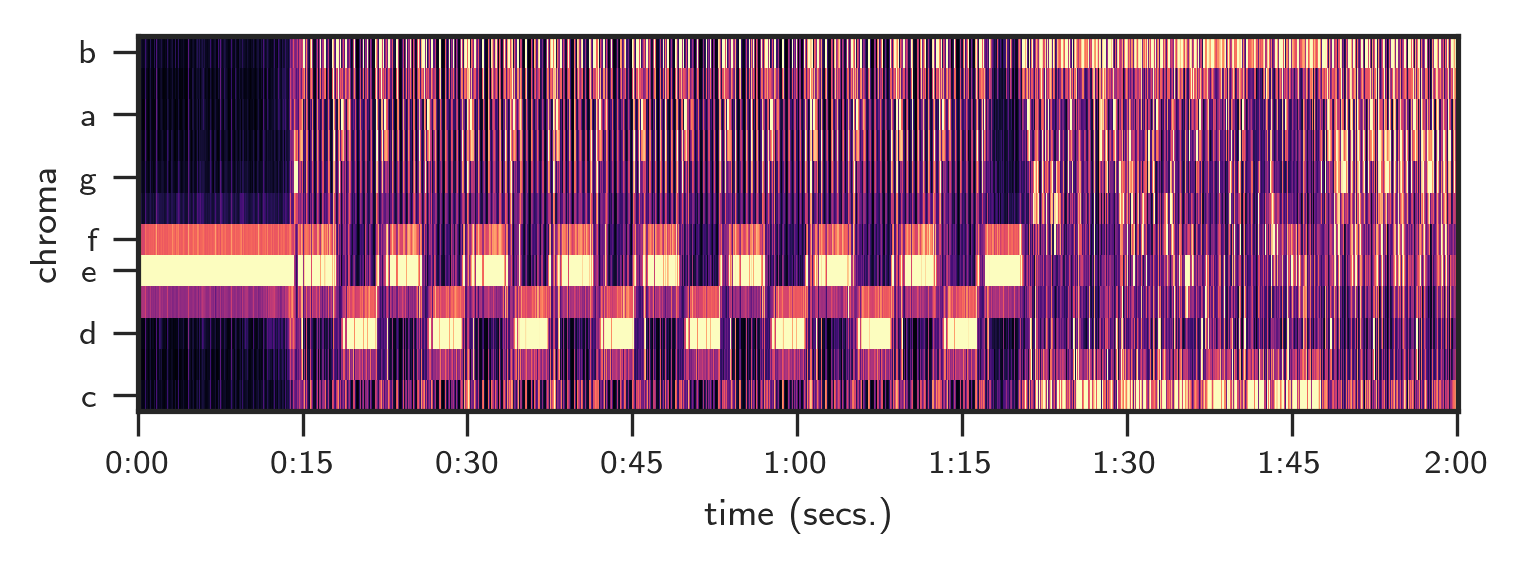

In [8]:
chroma_l = librosa.feature.chroma_cqt(y=np.array(sig), sr=SAMPLE_RATE, hop_length=HOP_SIZE, 
                                      norm=NORMALIZATION, bins_per_octave=12, threshold=THRESHOLD, cqt_mode=CQT_MODE)

# 12 bin per octave!
plot_chroma(chroma_l, "name")

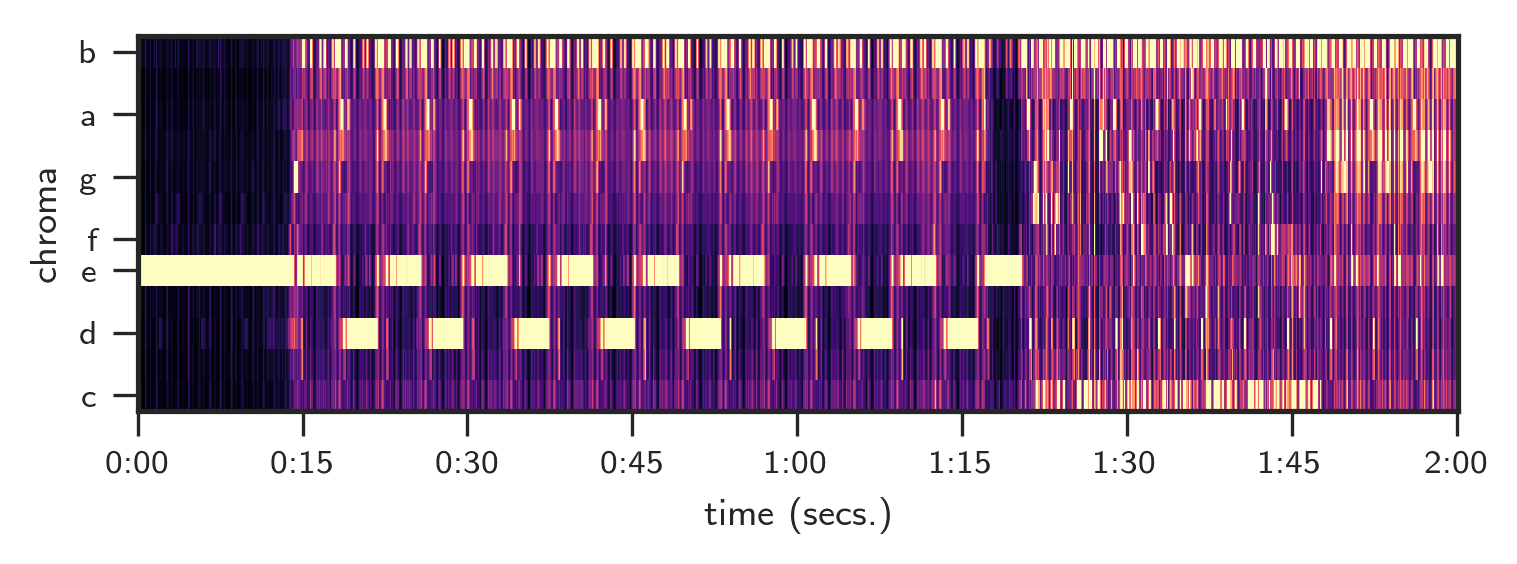

In [10]:
# use no less than three bins per semitone in order to be able to correct detuning
chroma_os = librosa.feature.chroma_cqt(y=np.array(sig), sr=SAMPLE_RATE, hop_length=HOP_SIZE, norm=NORMALIZATION, 
                                       threshold=THRESHOLD, bins_per_octave=36, cqt_mode=CQT_MODE)

plot_chroma(chroma_os, "36bin")

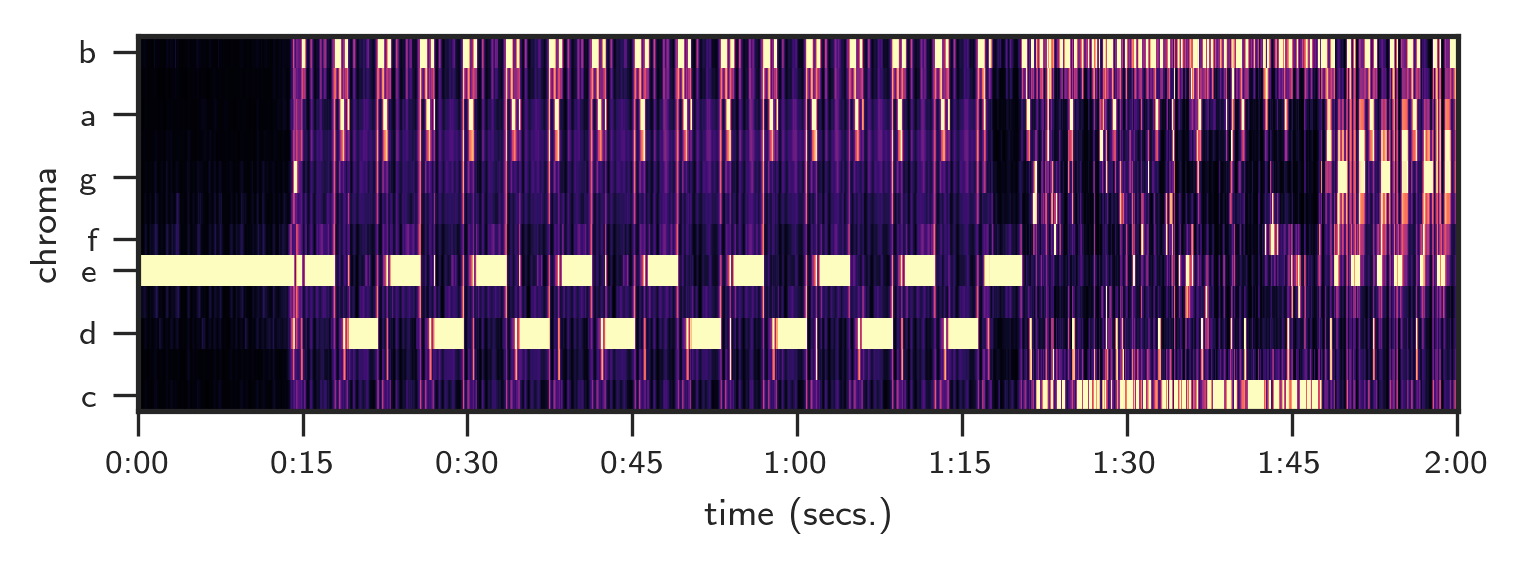

In [12]:
# percussive-harmonic separation
y_harm = librosa.effects.harmonic(y=np.array(sig), margin=4)

chroma_os_harm = librosa.feature.chroma_cqt(y=y_harm, sr=SAMPLE_RATE, hop_length=HOP_SIZE, norm=NORMALIZATION, 
                                       threshold=THRESHOLD, bins_per_octave=BINS_PER_OCTAVE, cqt_mode=CQT_MODE)

plot_chroma(chroma_os_harm, "Harmonic part")

In [15]:
#ANOTHER P/H SEPARATION
cqth = librosa.feature.chroma_cqt(y=librosa.effects.harmonic(y=np.array(sig), margin=8), 
                                  sr=SAMPLE_RATE,
                                  hop_length=HOP_SIZE,
                                  norm=np.inf,
                                  threshold=None,
                                  fmin=librosa.note_to_hz('A0'),
                                  n_octaves=6,
                                  bins_per_octave=36,
                                  n_chroma=12,
                                  cqt_mode='full')

In [ ]:
# EXPORT THE NORMALISED HARMONIC PART ONLY TO AN AUDIO FILE!!!
yh = np.multiply(y_harm, (1 / y_harm.max()))
madmom.audio.signal.write_wave_file(yh, filename="/Users/angel/Desktop/casa.wav",sample_rate=44100)

In [ ]:
# non-local filtering to remove any sparse additive noise from the features.
chroma_filter = np.minimum(chroma_os_harm,
                           librosa.decompose.nn_filter(chroma_os_harm, aggregate=np.median, metric='cosine')) 

plot_chroma(chroma_filter, "Non-local")

In [ ]:
# Local discontinuities and transients can be suppressed by using a horizontal median filter:
chroma_smooth = scipy.ndimage.median_filter(chroma_os_harm, size=(1, 9))

# chroma_filter.shape[1])
                                            
plot_chroma(chroma_filter, '/Users/angel/Dropbox/Apps/Texpad/Thesis/figures/_5.pdf')

In [ ]:
# FRAME COMPARISON OF DIFFERENT METHODS

chroma1 = chroma_orig.transpose()
chroma2 = chroma_os.transpose()
chroma3 = chroma_os_harm.transpose()
chroma4 = chroma_filter.transpose()
chroma5 = chroma_smooth.transpose()

window_n = np.random.randint(chroma2.shape[0])
print('frame_n {}'.format(window_n))

plt.figure(figsize=(20,5))
ax = plt.gca()
ax.plot(chroma1[window_n], label='cqt')
ax.plot(chroma2[window_n], label='3x')
ax.plot(chroma3[window_n], label='harmonic')
ax.plot(chroma4[window_n], label='non-local') 
ax.plot(chroma5[window_n], label='median')
ax.set_xlabel('Pitch class')
ax.legend(frameon=True)


In [14]:
cqthe = np.power(cqth, 10)

# to remove passing notes and other possible short artifacts
cqthef = np.minimum(cqthe, librosa.decompose.nn_filter(cqthe, aggregate=np.median, metric='cosine'))

# Local discontinuities and transients can be suppressed by using a horizontal median filter:
cqthefs = scipy.ndimage.median_filter(cqthef, size=(1, 9))

# we could binarize it... or not.
# cqthef = binarize(cqthe, 0.2)


# aggregation of vectors
# ======================
aggregate_all = np.sum(cqthefs, axis=1)
scale_all = np.divide(aggregate_all, np.max(aggregate_all))


# manipulations on the aggregated vector:
# =======================================

# sub-arrays with only NON-ZERO elements (in descending order of duration)
weights_sorted = np.flip(np.sort(scale_all[scale_all > 0.1]), axis=0)
pcs_by_weigth = (np.flip(np.argsort(scale_all), axis=0))[:weights_sorted.size]
pcs_ascending = np.sort(pcs_by_weigth)
pcs_from_longest = np.roll(pcs_ascending, -1 * np.where(pcs_ascending==pcs_by_weigth[0])[0][0])

print('sorted from most frequent: {}, according to weights {}'.format(pcs_by_weigth, weights_sorted))
print('sorted in ascending order from pc-0: {}'.format(pcs_ascending))
print(pcs_from_longest)

NameError: name 'cqth' is not defined

In [ ]:
# create plots
# ============
plt.figure(figsize=(20,15))
plt.subplot(5,1,1)
librosa.display.specshow(cqth, y_axis='chroma')
plt.colorbar()
plt.ylabel('CQT')

plt.subplot(5,1,2)
librosa.display.specshow(cqthe, y_axis='chroma')
plt.colorbar()
plt.ylabel('CQTH^10')
plt.tight_layout()

plt.subplot(5,1,3)
librosa.display.specshow(cqthef, y_axis='chroma')
plt.colorbar()
plt.ylabel('NON-LOCAL FILTER')
plt.tight_layout()

plt.subplot(5,1,4)
librosa.display.specshow(cqthefs, y_axis='chroma', x_axis="time")
plt.colorbar()
plt.ylabel('SMOOTHING')
plt.tight_layout()

plt.subplot(5,1,5)
ax = plt.gca()
ax.plot(scale_all)
ax.set_xlabel('PITCH CLASS')
ax.set_ylabel('RELATIVE DURATION')
plt.tight_layout()

plt.show()